In [1]:
from torch.utils.data import Dataset
import torch
import glob
import pandas as pd
from datetime import datetime
import os
import math
from tqdm import tqdm
import numpy as np

from scipy import signal

/home/yhbedoya/VirtualEnvs/SHMmae_venv/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
start_time, end_time = "05/12/2021 00:00", "07/12/2021 00:00"
path = '/home/yhbedoya/Repositories/SHM-MAE/traffic/20211205/'

print(f'reading CSV files')
start = datetime.strptime(start_time, '%d/%m/%Y %H:%M')
end = datetime.strptime(end_time, '%d/%m/%Y %H:%M')

ldf = list()
for p in tqdm(glob.glob(path + "*.csv")):
    name = os.path.split(p)[-1]
    nstr = datetime.strptime(name, 'traffic_%Y%m%dH%H%M%S.csv')
    if start <= nstr < end:
        df_tmp = pd.read_csv(p)
        c_drop = set(df_tmp.columns) - set(["sens_pos", "z", "ts"])
        if len(c_drop) > 0:
            df_tmp.drop(columns=list(c_drop), inplace=True)
        df_tmp = df_tmp[df_tmp["sens_pos"]== "C1.1.1"]
        ldf.append(df_tmp)
df = pd.concat(ldf).sort_values(by=['sens_pos', 'ts'])
df.reset_index(inplace=True, drop=True)

#df = df[df['sens_pos'].isin(self.sensors)]
df['ts'] = pd.to_datetime(df['ts'], unit='ms')
data = df[df["sens_pos"]== "C1.1.1"]
data["zN"] = data["z"]-np.mean(data["z"])

reading CSV files


100%|██████████| 1450/1450 [11:33<00:00,  2.09it/s]


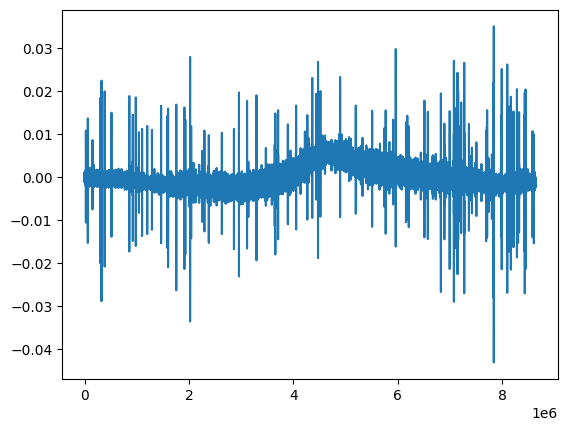

In [3]:
import matplotlib.pyplot as plt

plt.plot(data["zN"])
plt.show()

In [6]:
data["vars"] = data["zN"].rolling(window=5).var().fillna(0)

(0.0, 1e-06)

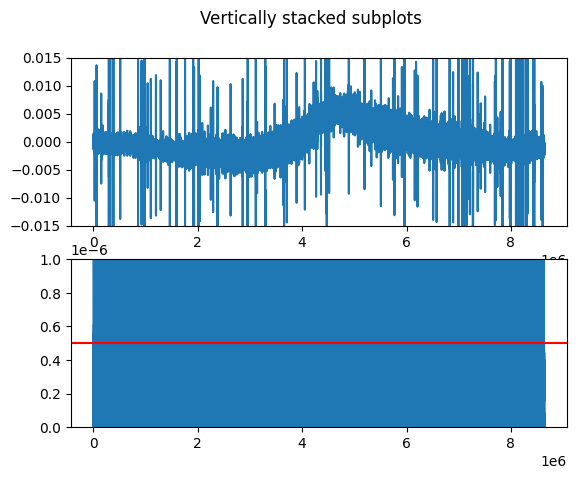

In [7]:
fig, axs = plt.subplots(2)
fig.suptitle('Vertically stacked subplots')
axs[0].plot(data["zN"])
axs[0].set_ylim(-0.015, 0.015)
axs[1].plot(data["vars"])
axs[1].axhline(y=5e-7, color='r')
axs[1].set_ylim(0, 1e-6)

In [55]:
slice = data[(data["ts"]>= "2021-12-05 00:04:10") & (data["ts"]<= "2021-12-05 00:04:30")]
slice["mean"] = data["zN"].rolling(window=500).mean().fillna(0)
slice["stds"] = data["zN"].rolling(window=500).std().fillna(0)
slice["soft"] = ((slice["zN"] - slice["mean"]).abs() / slice["stds"])

/home/yhbedoya/VirtualEnvs/SHMmae_venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/yhbedoya/VirtualEnvs/SHMmae_venv/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/yhbedoya/VirtualEnvs/SHMmae_venv/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy 

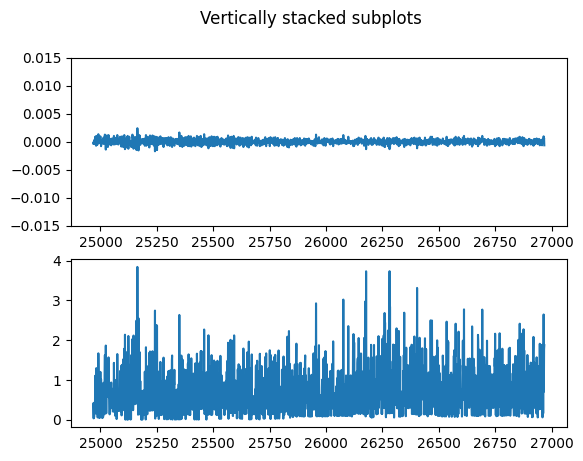

In [56]:
fig, axs = plt.subplots(2)
fig.suptitle('Vertically stacked subplots')
axs[0].plot(slice["zN"])
axs[0].set_ylim(-0.015, 0.015)
axs[1].plot(slice["soft"])

In [4]:
data

,sens_pos,z,ts,zN
0,C1.1.1,-0.988022,2021-12-05 00:00:00.311,0.000267
1,C1.1.1,-0.988098,2021-12-05 00:00:00.321,0.000191
2,C1.1.1,-0.988403,2021-12-05 00:00:00.331,-0.000114
3,C1.1.1,-0.987945,2021-12-05 00:00:00.341,0.000343
4,C1.1.1,-0.988479,2021-12-05 00:00:00.351,-0.000191
...,...,...,...,...
8639648,C1.1.1,-0.989700,2021-12-06 00:00:00.791,-0.001411
8639649,C1.1.1,-0.989929,2021-12-06 00:00:00.801,-0.001640
8639650,C1.1.1,-0.989929,2021-12-06 00:00:00.811,-0.001640
8639651,C1.1.1,-0.989929,2021-12-06 00:00:00.821,-0.001640


In [7]:
threshold = 5e-7
data["outlier"] = data.apply(lambda row: True if row["vars"]>= threshold else False, axis=1)
data

,sens_pos,z,ts,zN,vars,outlier
0,C1.1.1,-0.988022,2021-12-05 00:00:00.311,0.000267,0.000000e+00,False
1,C1.1.1,-0.988098,2021-12-05 00:00:00.321,0.000191,0.000000e+00,False
2,C1.1.1,-0.988403,2021-12-05 00:00:00.331,-0.000114,0.000000e+00,False
3,C1.1.1,-0.987945,2021-12-05 00:00:00.341,0.000343,0.000000e+00,False
4,C1.1.1,-0.988479,2021-12-05 00:00:00.351,-0.000191,5.646315e-08,False
...,...,...,...,...,...,...
8639648,C1.1.1,-0.989700,2021-12-06 00:00:00.791,-0.001411,5.238849e-08,False
8639649,C1.1.1,-0.989929,2021-12-06 00:00:00.801,-0.001640,5.238849e-08,False
8639650,C1.1.1,-0.989929,2021-12-06 00:00:00.811,-0.001640,1.047770e-08,False
8639651,C1.1.1,-0.989929,2021-12-06 00:00:00.821,-0.001640,1.164189e-08,False


In [8]:
outliers = data[data["outlier"] == True].reset_index().to_dict("records")
outliers

[{'index': 3670,
  'sens_pos': 'C1.1.1',
  'z': -0.9872587167162584,
  'ts': Timestamp('2021-12-05 00:00:37.011000'),
  'zN': 0.0010300818631083786,
  'vars': 5.052579158592765e-07,
  'outlier': True},
 {'index': 3671,
  'sens_pos': 'C1.1.1',
  'z': -0.9883268482490272,
  'ts': Timestamp('2021-12-05 00:00:37.021000'),
  'zN': -3.804966966036716e-05,
  'vars': 5.006011608744078e-07,
  'outlier': True},
 {'index': 3672,
  'sens_pos': 'C1.1.1',
  'z': -0.98794537270161,
  'ts': Timestamp('2021-12-05 00:00:37.031000'),
  'zN': 0.00034342587775682,
  'vars': 5.297058795298689e-07,
  'outlier': True},
 {'index': 5372,
  'sens_pos': 'C1.1.1',
  'z': -0.9891660944533456,
  'ts': Timestamp('2021-12-05 00:00:54.031000'),
  'zN': -0.0008772958739787784,
  'vars': 5.547359375734816e-07,
  'outlier': True},
 {'index': 6416,
  'sens_pos': 'C1.1.1',
  'z': -0.9892423895628292,
  'ts': Timestamp('2021-12-05 00:01:04.471000'),
  'zN': -0.0009535909834623713,
  'vars': 5.512433713349309e-07,
  'outlier'

In [25]:
groups = {}
statistics = []
group = []
powers = []
durations = []
last = 0
indexGroup = 0
timeStart = outliers[0]["ts"]
flag = True
for outlier in tqdm(outliers):
    if ((outlier["index"] - last) < 100) or flag:
        group.append(outlier)
        flag = False
        timeEnd = outlier["ts"]
    else:
        start, end = group[0]["index"], group[-1]["index"]
        duration = end-start
        groups[indexGroup] = group
        if (duration)>25:
            signalPower = np.sqrt(np.mean(np.array(data["zN"].iloc[start:end])**2))**2 
            #signalPower = np.var(data["zN"].iloc[start:end])
            statistics.append({"timeStart": timeStart,
            "timeEnd": timeEnd,
            "duration": duration,
            "signalPower": signalPower,
            "group": indexGroup}) #(group, timeStart, timeEnd)

        indexGroup += 1
        group = [outlier,]
        timeStart = outlier["ts"]
        timeEnd = outlier["ts"]
    last = outlier["index"]

100%|██████████| 348595/348595 [00:00<00:00, 917756.91it/s]


In [26]:
pd.options.display.precision = 10
statisticsDf = pd.DataFrame(statistics)
statisticsDf

,timeStart,timeEnd,duration,signalPower,group
0,2021-12-05 00:01:04.471,2021-12-05 00:01:05.801,133,0.0000003726,2
1,2021-12-05 00:03:35.071,2021-12-05 00:03:35.721,65,0.0000004529,12
2,2021-12-05 00:03:38.691,2021-12-05 00:03:39.601,91,0.0000001433,13
3,2021-12-05 00:03:59.661,2021-12-05 00:04:16.851,1719,0.0000024965,16
4,2021-12-05 00:05:03.221,2021-12-05 00:05:03.741,52,0.0000004525,24
...,...,...,...,...,...
5870,2021-12-05 23:55:55.211,2021-12-05 23:55:56.681,147,0.0000023714,10384
5871,2021-12-05 23:56:02.731,2021-12-05 23:56:04.221,149,0.0000018929,10385
5872,2021-12-05 23:56:05.231,2021-12-05 23:56:05.871,64,0.0000028980,10386
5873,2021-12-05 23:57:13.681,2021-12-05 23:57:14.901,122,0.0000020587,10390


(array([2.461e+03, 1.226e+03, 8.580e+02, 3.340e+02, 2.320e+02, 1.850e+02,
        1.100e+02, 1.010e+02, 7.500e+01, 6.600e+01, 3.300e+01, 3.400e+01,
        2.000e+01, 9.000e+00, 1.500e+01, 1.400e+01, 1.500e+01, 8.000e+00,
        5.000e+00, 5.000e+00, 8.000e+00, 8.000e+00, 5.000e+00, 8.000e+00,
        6.000e+00, 9.000e+00, 8.000e+00, 4.000e+00, 1.000e+00, 1.000e+00,
        5.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([  26.  ,   81.42,  136.84,  192.26,  247.68,  303.1 ,  358.52,
         413.94,  469.36,  524.78,  580.2 ,  635.62,  691.04,  746.46,
         801.88,  857.3 ,  912.72,  968.14, 1023.56, 1078.98, 1134.4 ,
        1189.82, 1245.24, 1300.66, 1356.08, 1411.5 , 1466.92, 1522.34,
        1577.76, 1633.18, 1688.6 , 1744.02, 1799.44, 1854.86, 1910.28,
        1965.7 , 2021

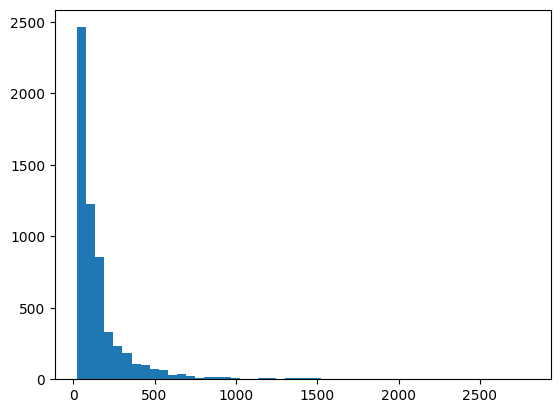

In [28]:
plt.hist(statisticsDf["duration"],bins=50)

In [11]:
pesaDataDf = pd.read_csv("/home/yhbedoya/Repositories/SHM-MAE/dati_pese_dinamiche/dati 2021-12-04_2021-12-12 pesa km 104,450.csv", sep=";", index_col=0)
pesaDataDf = pesaDataDf[["Id", "StartTimeStr", "ClassId", "GrossWeight", "Velocity", "VelocityUnit"]]
pesaDataDf["Time"] = pd.to_datetime(pesaDataDf["StartTimeStr"])
pesaDataDf["Time"] = pesaDataDf["Time"].dt.strftime('%Y-%d-%m %H:%M:00')
pesaDataDf["Time"] = pd.to_datetime(pesaDataDf["Time"]) + pd.to_timedelta(-1,'H')
pesaDataDf["EstimatedTime"] = pesaDataDf["Time"] + pd.to_timedelta(600/(pesaDataDf["Velocity"]/3.6),'S')
pesaDataDf["MaxTime"] = pesaDataDf["EstimatedTime"] + pd.to_timedelta(60,'S')
pesaDataDf["Time"] = pd.to_datetime(pesaDataDf["Time"]).dt.strftime('%Y-%m-%d %H:%M:00')
labelsDf = pesaDataDf[(pesaDataDf["Time"]>="2021-12-05 00:00:00") & (pesaDataDf["Time"]<="2021-12-06 00:00:00")]

In [57]:
labelsDf.shape

(53266, 9)

(array([1.085e+03, 5.544e+03, 5.570e+02, 1.150e+02, 1.600e+01, 3.000e+00,
        1.000e+00, 0.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 3.000e+00, 4.000e+00, 1.100e+01, 6.000e+00,
        6.000e+00, 3.000e+00, 2.000e+00, 5.000e+00, 6.000e+00, 2.000e+00,
        3.000e+00, 3.000e+00, 4.000e+00, 2.000e+00, 5.000e+00, 2.000e+00,
        1.000e+00, 0.000e+00, 3.000e+00, 2.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 3.000e+00, 1.000e+00,
        1.000e+00, 0.000e+00, 3.000e+00, 0.000e+00, 1.000e+00, 2.000e+00,
        0.000e+00, 4.000e+00]),
 array([  300. ,  1277.5,  2255. ,  3232.5,  4210. ,  5187.5,  6165. ,
         7142.5,  8120. ,  9097.5, 10075. , 11052.5, 12030. , 13007.5,
        13985. , 14962.5, 15940. , 16917.5, 17895. , 18872.5, 19850. ,
        20827.5, 21805. , 22782.5, 23760. , 24737.5, 25715. , 26692.5,
        27670. , 28647.5, 29625. , 30602.5, 31580. , 32557.5, 33535. ,
        34512.5, 3549

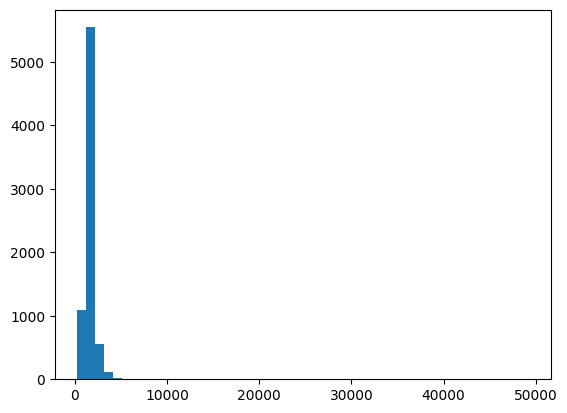

In [29]:
plt.hist(labelsDf["GrossWeight"],bins=50)

In [58]:
def labelAssigner(row):
    candidatesDf = statisticsDf[(statisticsDf["timeStart"]>= row["EstimatedTime"]) & (statisticsDf["timeStart"]<= row["MaxTime"])]
    return list(candidatesDf.index)

In [12]:
def labelAssigner2(row):
    candidatesDf = statisticsDf[(statisticsDf["timeStart"]>= row["EstimatedTime"]) & (statisticsDf["timeStart"]<= row["MaxTime"])]
    if len(candidatesDf) == 1:
        return candidatesDf.iloc[0]["signalPower"]
        #return candidatesDf.index.values.astype(int)
    else:
        return np.nan

In [13]:
labelsDf["candidates"] = labelsDf.apply(labelAssigner2, axis=1)
labelsDf

/home/yhbedoya/VirtualEnvs/SHMmae_venv/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Id,StartTimeStr,ClassId,GrossWeight,Velocity,VelocityUnit,Time,EstimatedTime,MaxTime,candidates
N.,,,,,,,,,,
39413,59785,06/12/2021 00:57,Classe 1,1280,106,Km/h,2021-12-05 23:57:00,2021-12-05 23:57:20.377358491,2021-12-05 23:58:20.377358491,9.4040141694e-13
39414,59784,06/12/2021 00:55,Classe 1,1080,76,Km/h,2021-12-05 23:55:00,2021-12-05 23:55:28.421052632,2021-12-05 23:56:28.421052632,NaN
39415,59783,06/12/2021 00:54,Classe 1,1215,107,Km/h,2021-12-05 23:54:00,2021-12-05 23:54:20.186915888,2021-12-05 23:55:20.186915888,NaN
39416,59782,06/12/2021 00:54,Classe 1,1330,100,Km/h,2021-12-05 23:54:00,2021-12-05 23:54:21.600000000,2021-12-05 23:55:21.600000000,NaN
39417,59781,06/12/2021 00:54,Classe 1,1225,80,Km/h,2021-12-05 23:54:00,2021-12-05 23:54:27.000000000,2021-12-05 23:55:27.000000000,NaN
...,...,...,...,...,...,...,...,...,...,...
46823,52375,05/12/2021 01:04,Classe 1,2080,91,Km/h,2021-12-05 00:04:00,2021-12-05 00:04:23.736263736,2021-12-05 00:05:23.736263736,NaN
46824,52374,05/12/2021 01:04,Classe 1,1195,96,Km/h,2021-12-05 00:04:00,2021-12-05 00:04:22.500000000,2021-12-05 00:05:22.500000000,NaN
46825,52373,05/12/2021 01:03,Classe 9,24720,77,Km/h,2021-12-05 00:03:00,2021-12-05 00:03:28.051948052,2021-12-05 00:04:28.051948052,NaN


In [32]:
aggDf = pesaDataDf.groupby(["Time"])["Id"].count()
aggDf = aggDf.reset_index()
aggDf["Time"] = pd.to_datetime(aggDf["Time"]).dt.strftime('%Y-%m-%d %H:%M:00')
aggDf.rename(columns={"Id": "Vehicles"}, inplace=True)
aggDf

,Time,Vehicles
0,2021-12-03 23:13:00,2
1,2021-12-03 23:32:00,2
2,2021-12-04 02:57:00,1
3,2021-12-04 03:22:00,1
4,2021-12-04 03:50:00,2
...,...,...
9816,2021-12-12 22:48:00,4
9817,2021-12-12 22:52:00,1
9818,2021-12-12 22:54:00,1
9819,2021-12-12 22:55:00,1


In [33]:
aggDf[aggDf["Vehicles"]==1]

,Time,Vehicles
2,2021-12-04 02:57:00,1
3,2021-12-04 03:22:00,1
6,2021-12-04 03:56:00,1
7,2021-12-04 03:57:00,1
10,2021-12-04 04:05:00,1
...,...,...
9814,2021-12-12 22:45:00,1
9817,2021-12-12 22:52:00,1
9818,2021-12-12 22:54:00,1
9819,2021-12-12 22:55:00,1


In [86]:
threshold = 5e-7
outliers = []
for i in range(len(vars)):
    if vars[i] > threshold:
        outliers.append(i)

groups = {}
times = {}
sep = {}
group = []
last = 0
indexGroup = 0
timeStart = dates[outliers[0]]
flag = True
for outlier in outliers:
    if ((outlier - last) < 100) or flag:
        group.append(outlier)
        flag = False
        timeEnd = dates[outlier]
    else:
        groups[indexGroup] = group
        sep[indexGroup] = (outlier - last)
        duration = group[-1]-group[0]
        if (duration)>25:
            times[indexGroup] = (timeStart, timeEnd, duration) #(group, timeStart, timeEnd)

        indexGroup += 1
        group = [outlier,]
        timeStart = dates[outlier]
        timeEnd = dates[outlier]
    last = outlier


In [87]:
times

{1: (Timestamp('2021-12-05 00:01:04.731000'),
  Timestamp('2021-12-05 00:01:05.651000'),
  92),
 5: (Timestamp('2021-12-05 00:03:35.361000'),
  Timestamp('2021-12-05 00:03:35.751000'),
  39),
 8: (Timestamp('2021-12-05 00:03:59.731000'),
  Timestamp('2021-12-05 00:04:14.961000'),
  1523),
 14: (Timestamp('2021-12-05 00:05:03.411000'),
  Timestamp('2021-12-05 00:05:03.781000'),
  37),
 15: (Timestamp('2021-12-05 00:05:12.271000'),
  Timestamp('2021-12-05 00:05:13.041000'),
  77),
 16: (Timestamp('2021-12-05 00:05:15.191000'),
  Timestamp('2021-12-05 00:05:15.941000'),
  75),
 19: (Timestamp('2021-12-05 00:06:03.131000'),
  Timestamp('2021-12-05 00:06:04.461000'),
  133),
 21: (Timestamp('2021-12-05 00:06:59.341000'),
  Timestamp('2021-12-05 00:06:59.661000'),
  32),
 23: (Timestamp('2021-12-05 00:08:09.071000'),
  Timestamp('2021-12-05 00:08:09.611000'),
  54),
 29: (Timestamp('2021-12-05 00:10:06.681000'),
  Timestamp('2021-12-05 00:10:18.821000'),
  1214),
 30: (Timestamp('2021-12-05 

In [88]:
len(times)

32

/home/yhbedoya/VirtualEnvs/SHMmae_venv/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
slice = data[(data["ts"]>= "2021-12-05 00:04:10") & (data["ts"]<= "2021-12-05 00:04:20")]

plt.plot(slice["z2"])
plt.ylim(-0.015, 0.015)
plt.show()

(0.0, 5e-06)

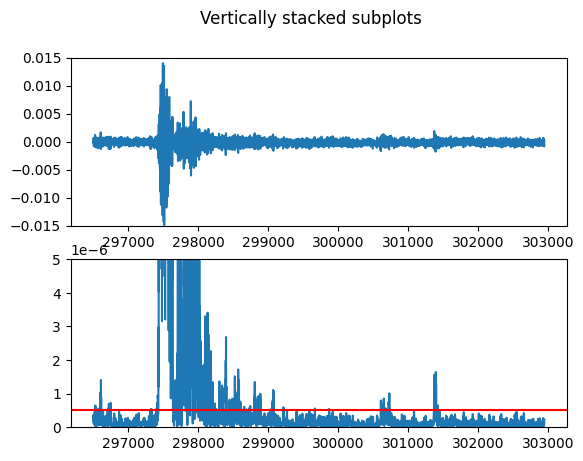

In [61]:
slice = data[(data["ts"]>= "2021-12-05 00:49:25.5") & (data["ts"]<= "2021-12-05 00:50:30")]

fig, axs = plt.subplots(2)
fig.suptitle('Vertically stacked subplots')
axs[0].plot(slice["zN"])
axs[0].set_ylim(-0.015, 0.015)
axs[1].plot(slice["vars"])
axs[1].axhline(y=5e-7, color='r')
axs[1].set_ylim(0, 5e-6)

In [18]:
sep

{0: 117,
 1: 362,
 2: 104,
 3: 2255,
 4: 849,
 5: 215,
 6: 2001,
 7: 1902,
 8: 4390,
 9: 1096,
 10: 253,
 11: 6687,
 12: 3469,
 13: 2861,
 14: 485,
 15: 2260,
 16: 1450,
 17: 149,
 18: 644}

(0.0, 5.0)

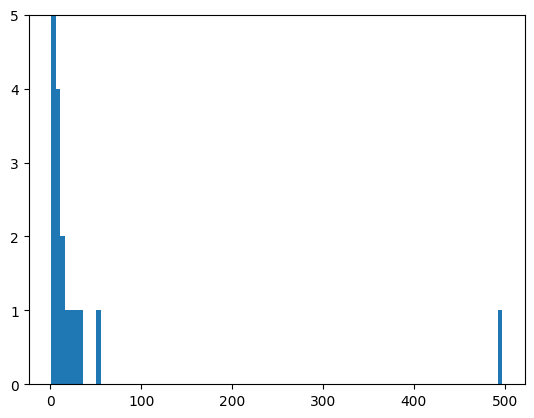

In [118]:
lens = []
for k, v in groups.items():
    if len(v) > 0:
        lens.append(len(v))

plt.hist(lens, bins=100)
plt.ylim(0, 5)

In [24]:
from datetime import datetime
from datetime import timedelta

datetime_str = '2021-12-05 00:03:00'

datetime_object = datetime.strptime(datetime_str, '%Y-%m-%d %H:%M:%S')

print(type(datetime_object))
print(datetime_object)  # printed in default format


<class 'datetime.datetime'>
2021-12-05 00:03:00


In [25]:
print(datetime_object.strftime('%Y-%m-%d %H:%M:%S'))

2021-12-05 00:03:00
